# Final experiments: varying environmental relative humidity

Thomas Schanzer z5310829  
School of Physics, UNSW  
November 2021

In this notebook, we vary the relative humidity of the upper atmosphere, fixing the entrainment rate and initial conditions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(
    {'font.size': 16, 'text.usetex': True, 'font.family': 'serif',
     'font.serif': ['Computer Modern Roman']})

import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as const
from metpy.units import concatenate
from metpy.plots import SkewT

import sys
from os import mkdir
from os.path import exists

sys.path.append('../../scripts/')
from environment import idealised_sounding
from thermo import moist_lapse, saturation_specific_humidity, dcape_dcin
from thermo import temperature_change
from entraining_parcel import EntrainingParcel

In [2]:
fig_path = '20211110_varying_env_humidity_figures/'
if not exists(fig_path):
    mkdir(fig_path)

In [20]:
relative_humidity = np.arange(0.3, 0.901, 0.025)
soundings = []
parcels = []
for rh in relative_humidity:
    sounding = idealised_sounding(rh)
    dcape, dcin = dcape_dcin(sounding)
    sounding.dcape = dcape
    sounding.dcin = dcin
    
    soundings.append(sounding)
    parcels.append(EntrainingParcel(soundings[-1]))

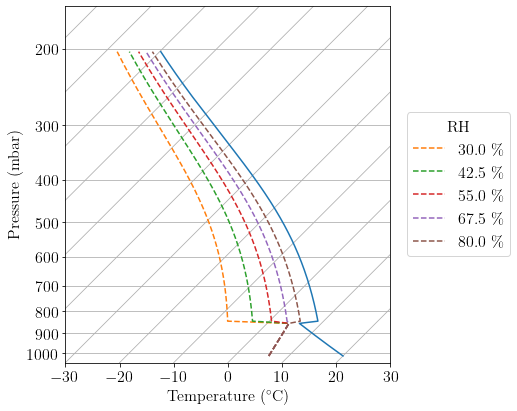

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [19]:
fig = plt.figure(figsize=(7,6))
skew = SkewT(fig, rotation=45)
skew.plot(soundings[0]._pressure_raw, soundings[0]._temperature_raw)
for sounding, rh in zip(soundings[::5], relative_humidity[::5]):
    skew.plot(sounding._pressure_raw, sounding._dewpoint_raw, '--',
              label='{:.1f} \%'.format(rh*100))
lgd = skew.ax.legend(loc=[1.05, 0.3])
lgd.set_title('RH')
skew.ax.set_xlim(-30, 30)
skew.ax.set_ylim(top=160)
skew.ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)')
fig.tight_layout()
plt.show()
fig.savefig(fig_path + 'skewt.eps', facecolor='w', bbox_inches='tight')

## Experiments

In [49]:
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
time = np.arange(0, 10.01, 0.01)*units.minute
rate = 1/units.km
l_initial = 2e-3*units.dimensionless

In [50]:
%%time
sols = []
for i, parcel in enumerate(parcels):
    p_initial = soundings[i].pressure(z_initial)
    t_initial = soundings[i].wetbulb_temperature(z_initial)
    q_initial = saturation_specific_humidity(p_initial, t_initial)
    sys.stdout.write('\rCalculation {} of {}    '.format(i+1, len(parcels)))
    sol = parcel.motion(
        time, z_initial, w_initial, t_initial, q_initial, l_initial, rate,
        kind='reversible')
    sols.append(sol)
sys.stdout.write('\n')

Calculation 25 of 25    
CPU times: user 7min 30s, sys: 3.06 s, total: 7min 33s
Wall time: 7min 48s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


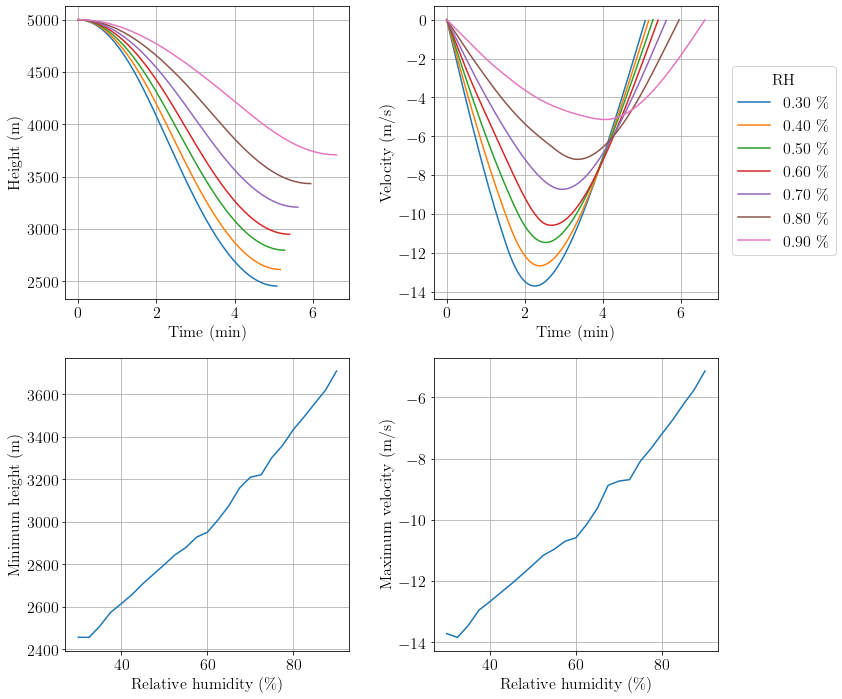

In [53]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(221)
for sol, rh in zip(sols[::4], relative_humidity[::4]):
    ax.plot(time, sol.height)
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Height (m)')

ax = fig.add_subplot(222)
for sol, rh in zip(sols[::4], relative_humidity[::4]):
    ax.plot(time, sol.velocity, label='{:.2f} \%'.format(rh))
lgd = ax.legend(loc=[1.05, 0.15])
lgd.set_title('RH')
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')

ax = fig.add_subplot(223)
ax.plot(relative_humidity*1e2, [sol.min_height.m for sol in sols])
ax.grid()
ax.set(
    xlabel='Relative humidity (\%)',
    ylabel='Minimum height (m)')

ax = fig.add_subplot(224)
ax.plot(relative_humidity*1e2, [np.nanmin(sol.velocity.m) for sol in sols])
ax.grid()
ax.set(
    xlabel='Relative humidity (\%)',
    ylabel='Maximum velocity (m/s)')

fig.tight_layout()
fig.savefig(fig_path + 'motion_vs_RH_2gram_1perkm.eps', facecolor='w',
            bbox_inches='tight')
plt.show()

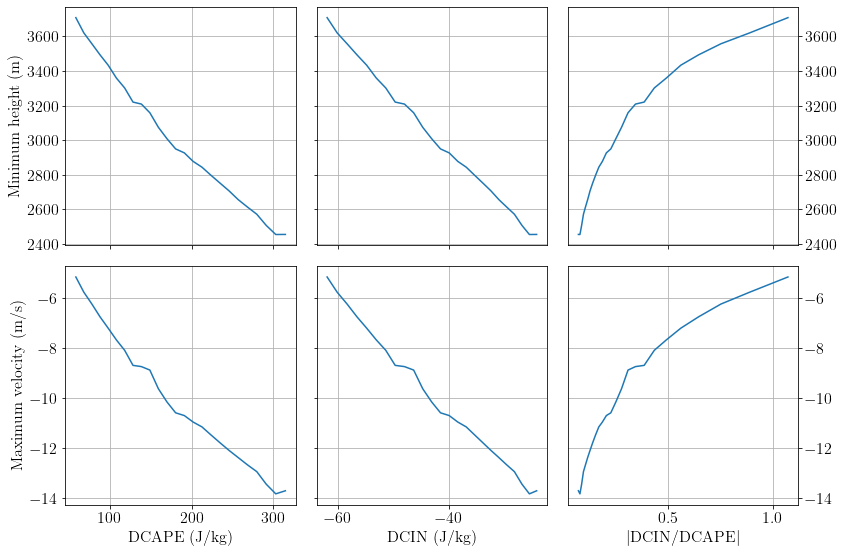

In [52]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(231)
ax.plot(
    [sounding.dcape.m for sounding in soundings],
    [sol.min_height.m for sol in sols])
ax.grid()
ax.set(ylabel='Minimum height (m)')
ax.set_xticklabels([])

ax = fig.add_subplot(234)
ax.plot(
    [sounding.dcape.m for sounding in soundings],
    [np.nanmin(sol.velocity.m) for sol in sols])
ax.grid()
ax.set(
    xlabel='DCAPE (J/kg)',
    ylabel='Maximum velocity (m/s)')

ax = fig.add_subplot(232)
ax.plot(
    [sounding.dcin.m for sounding in soundings],
    [sol.min_height.m for sol in sols])
ax.grid()
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(235)
ax.plot(
    [sounding.dcin.m for sounding in soundings],
    [np.nanmin(sol.velocity.m) for sol in sols])
ax.grid()
ax.set(xlabel='DCIN (J/kg)')
ax.set_yticklabels([])

ax = fig.add_subplot(233)
ax.plot(
    [-sounding.dcin.m/sounding.dcape.m for sounding in soundings],
    [sol.min_height.m for sol in sols])
ax.grid()
ax.set_xticklabels([])
ax.yaxis.tick_right()

ax = fig.add_subplot(236)
ax.plot(
    [-sounding.dcin.m/sounding.dcape.m for sounding in soundings],
    [np.nanmin(sol.velocity.m) for sol in sols])
ax.grid()
ax.set(xlabel='$|$DCIN/DCAPE$|$')
ax.yaxis.tick_right()

fig.tight_layout()
plt.show()
fig.savefig(fig_path + 'strength_vs_dcape_dcin_2gram_1perkm.eps',
            facecolor='w', bbox_inches='tight')